## 2.3 从预训练模型获取Embedding

### 2.3.1 背景说明

基于数据集IMDB进行情感分析，做预测之前需要对数据集进行预处理，把词转换为词嵌入（Embedding）。这里我们采用
迁移学习的方法来提升模型的性能，直接使用2014年英文维基百科的预计算词嵌入。文件名为glove.6B.zip 大小为822MB,里面包含400000个单词的100维嵌入向量。
把预训练好的词嵌入导入模型的第一层，并冻结该层，增加分类层进行分类预测。
GloVe词嵌入数据集的下载地址：https://nlp.stanford.edu/projects/glove/

### 2.3.2 下载IMDB数据集
这里我们把IMDB数据集下载放在本地了，目录为./aclImdb

In [1]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 2.3.3 进行分词

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 只保留前100单词的评论
training_samples = 200  # 在200个样本上训练
validation_samples = 10000  # W对10000个样品进行验证
max_words = 10000  # 只考虑数据集中最常见的10000 个单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集
# 首先打乱数据, 因一开始数据集是排序好的
# 负面评论在前, 正面评论在后
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### 2.3.4 下载并预处理GloVe词嵌入

载地址：https://nlp.stanford.edu/projects/glove/   
这是2014年英文维基百科的预计算词嵌入。文件名为glove.6B.zip 大小为822MB,里面包含400000个单词的100维嵌入向量。

1.对glove.6B.100d.txt进行解析，构建一个由单词映射为其向量表示的索引。

In [3]:
glove_dir = './glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [4]:
for key,value in embeddings_index.items():
    print(key,value)
    break

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

2.在embeddings_index字典的基础上，
构建一个矩阵,其形状为10000x100。对单词索引（word_index）中索引为i的单词，这个矩阵（embedding_matrix）的元素i就是这个单词对应的词向量（其维度为embedding_dim，即100）

In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 在嵌入索引(embedding index)找不到的词，其嵌入向量都设为0
            embedding_matrix[i] = embedding_vector

### 2.3.5 构建模型

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


在模型中加载GloVe嵌入,并冻结Embedding层。

In [9]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 2.3.6 训练模型

In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 3s 13ms/sample - loss: 1.7045 - acc: 0.5000 - val_loss: 0.6925 - val_acc: 0.5195
Epoch 2/10
200/200 [==============================] - 1s 7ms/sample - loss: 0.7033 - acc: 0.6700 - val_loss: 0.8451 - val_acc: 0.5055
Epoch 3/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.4142 - acc: 0.7950 - val_loss: 1.1305 - val_acc: 0.5003
Epoch 4/10
200/200 [==============================] - 1s 7ms/sample - loss: 0.2798 - acc: 0.9150 - val_loss: 1.1247 - val_acc: 0.5006
Epoch 5/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.3023 - acc: 0.8500 - val_loss: 0.7026 - val_acc: 0.5698
Epoch 6/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.1925 - acc: 0.9450 - val_loss: 0.7430 - val_acc: 0.5591
Epoch 7/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.2004 - acc: 0.9200 - val_loss: 0.7061 - val_acc: 0.5733
Epoch 8/10
20

### 2.3.7 可视化训练结果

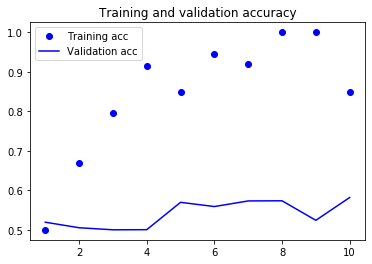

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

从上图可以看出，训练精度与验证精度相差较大，不过这里只使用了较少的训练数据，但验证准确率达到60%左右，说明效果很不错。

### 2.3.8 不使用预训练模型的情况

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())  #也可以替换为model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 3s 13ms/sample - loss: 0.6945 - acc: 0.4800 - val_loss: 0.6935 - val_acc: 0.5071
Epoch 2/10
200/200 [==============================] - 2s 8m

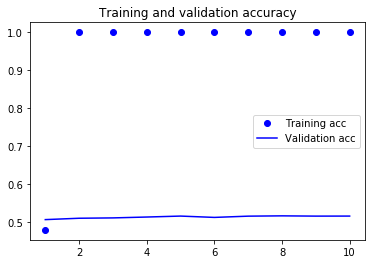

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


不使用预训练模型的验证准确率只有50%左右，因此，使用预训练词嵌入的模型性能优于没使用的模型性能。这是迁移学习魔力所在，
后面我们介绍的ELMo，BERT，GPT2等，从某个方面来说，都一种预训练嵌入模型，充分使用这些模型将大大提升下游任务的性能。